In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csc_matrix, kron
from scipy.sparse.linalg import expm
large = 40; med = 30; small = 20
params = {'axes.titlesize': med,
          'axes.titlepad' : med,
          'legend.fontsize': med,
          'axes.labelsize': med,
          'axes.titlesize': med,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': med}
plt.rcParams["font.family"] = "Helvetica"
plt.rcParams.update(params)

# Unitary

In [2]:
# class UnitaryVQE:
#      """
#      Finds the ground state of a self-consistent mean-field Hamiltonian
#      H(x) = (J*L*x)X - Delta*Z using a purely unitary variational algorithm.
#      This version is optimized to avoid local minima and uses corrected analytical gradients.
#      """

#      # --- Pauli Matrices (Class Attributes) ---
#      I2 = csc_matrix(np.eye(2, dtype=complex))
#      X = csc_matrix(np.array([[0, 1], [1, 0]], dtype=complex))
#      Y = csc_matrix(np.array([[0, -1j], [1j, 0]], dtype=complex))
#      Z = csc_matrix(np.array([[1, 0], [0, -1]], dtype=complex))

#      def __init__(self, J=1.0, Delta=0.5, L=1.0):
#           """
#           Initializes the optimizer with system parameters.
#           """
#           self.J = J
#           self.L = L
#           self.Delta = Delta
          
#           # --- Storage for results ---
#           self.cost_history = []
#           self.gradients_history = []
#           self.best_angles = None
#           self.best_cost = None
#           self.final_x = None

#      # --- Utility Methods for Liouvillian Formalism ---
#      @staticmethod
#      def _vectorize(rho):
#           """Converts a 2x2 density matrix to a 4x1 column vector."""
#           if hasattr(rho, "toarray"):
#                rho = rho.toarray()
#           return csc_matrix(rho.flatten(order="F")[:, None])

#      @staticmethod
#      def _unvectorize(rho_vec):
#           """Converts a 4x1 density vector back to a 2x2 matrix."""
#           rho_dense_vec = rho_vec.toarray() if hasattr(rho_vec, "toarray") else rho_vec
#           return csc_matrix(rho_dense_vec.reshape((2, 2), order="F"))

#      # --- Liouvillian Superoperators for the Ansatz ---
#      # These are dimensionless operators used in the variational form U = exp(θf*Lf)exp(θint*Lint)
#      def _L_int_ansatz(self, x_mean):
#           """Liouvillian for the ansatz interaction term: L_int = -i[x*X, .]"""
#           H_int = x_mean * self.X
#           return -1j * (kron(self.I2, H_int) - kron(H_int.T, self.I2))
     
#      def _L_f_ansatz(self):
#           """Liouvillian for the ansatz free term: L_f = -i[Z, .]"""
#           H_f = self.Z
#           return -1j * (kron(self.I2, H_f) - kron(H_f.T, self.I2))

#      # --- Cost Function and Gradients ---
#      def _get_hamiltonian(self, x_val):
#           """Constructs the total physical Hamiltonian matrix for a given x."""
#           return self.J * self.L * x_val * self.X - self.Delta * self.Z

#      def _cost_function(self, rho_final_mat, x_final):
#           """Cost function C = Tr(H(x_final) * rho_final)."""
#           H_final = self._get_hamiltonian(x_final)
#           return np.real(np.trace((H_final @ rho_final_mat).toarray()))

#      def _calculate_gradients(self, n_layers, evolvers, propagators, rho_history, x_history):
#           """Calculates the analytical gradients of the cost function."""
#           E_int_list, E_f_list = evolvers
#           grads = [[0.0] * 2 for _ in range(n_layers)]
#           rho_final_mat = self._unvectorize(rho_history[-1])
#           x_final = np.real(np.trace((self.X @ rho_final_mat).toarray()))

#           for l in range(n_layers):
#                # The propagator for all layers *after* the current layer l
#                propagator_after_layer = csc_matrix(np.eye(4, dtype=complex))
#                for i in range(l + 1, n_layers):
#                     # CORRECTED: Apply propagators from the end backwards
#                     propagator_after_layer = propagators[i] @ propagator_after_layer
               
#                # State before the current layer
#                rho_before_layer = rho_history[l]

#                """ 
#                The derivative of the cost function is computed using the product rule:
#                dC/dθ = d/dθ[Tr(Hρ)] = Tr[(dH/dθ)ρ] + Tr[H(dρ/dθ)]
#                Since H depends on x, and x depends on ρ, which depends on θ, we have:
#                dH/dθ = (dH/dx)(dx/dθ) = (J*L*X) * Tr[X(dρ/dθ)]
#                So, dC/dθ = J*L*Tr[X(dρ/dθ)]*Tr[Xρ] + Tr[H(dρ/dθ)]
#                """
#                def get_full_gradient(d_rho_final_mat):
#                     # Hamiltonian at this iteration
#                     H_final = self._get_hamiltonian(x_final)
#                     # First term: Tr[H(dρ/dθ)]
#                     term1 = np.real(np.trace((H_final @ d_rho_final_mat).toarray()))
#                     # dx/dθ = Tr[X(dρ/dθ)]
#                     dx_dtheta = np.real(np.trace((self.X @ d_rho_final_mat).toarray()))
#                     # Second term: J*L*x_final*(dx/dθ)
#                     term2 = self.J * self.L * x_final * dx_dtheta
#                     return term1 + term2

#                # State after the first part of the layer l evolution
#                rho_after_int = E_int_list[l] @ rho_before_layer
               
#                # --- Gradient for theta_int ---
#                # ∂(E_int)/∂θ_int = L_int_ansatz * E_int
#                # The derivative must use the same Liouvillian as the variational ansatz.
#                d_rho_vec_int = self._L_int_ansatz(x_history[l]) @ rho_after_int
#                d_rho_vec_int = E_f_list[l] @ d_rho_vec_int
#                d_rho_final_mat_int = self._unvectorize(propagator_after_layer @ d_rho_vec_int)
#                grads[l][0] = get_full_gradient(d_rho_final_mat_int)

#                # --- Gradient for theta_f ---
#                # ∂(E_f)/∂θ_f = L_f_ansatz * E_f
#                # Similarly, use the ansatz Liouvillian for the derivative with respect to θ_f.
#                d_rho_vec_f = self._L_f_ansatz() @ (E_f_list[l] @ rho_after_int)
#                d_rho_final_mat_f = self._unvectorize(propagator_after_layer @ d_rho_vec_f)
#                grads[l][1] = get_full_gradient(d_rho_final_mat_f)
               
#           return grads

#      # --- VQA Core Logic ---
#      def _variational_ansatz(self, n_layers, angles_list, rho_initial_vec):
#           """Applies the ansatz U = e^(θf*Lf) * e^(θint*Lint) for all layers."""
#           rho_vec = rho_initial_vec.copy()
#           rho_history, x_history = [rho_vec], []
#           evolvers = ([], []) 
#           propagators = []

#           # Calculate the initial x value before the first layer
#           x_current = np.real(np.trace((self.X @ self._unvectorize(rho_vec)).toarray()))

#           for i in range(n_layers):
#                theta_int, theta_f = angles_list[i]
#                # x_history stores the <X> value *before* each layer's evolution
#                x_history.append(x_current)

#                E_int = expm(theta_int * self._L_int_ansatz(x_current))
#                E_f   = expm(theta_f   * self._L_f_ansatz())
               
#                M = E_f @ E_int
#                rho_vec = M @ rho_vec
               
#                # Update x_current with the value *after* the layer's evolution
#                x_current = np.real(np.trace((self.X @ self._unvectorize(rho_vec)).toarray()))
               
#                rho_history.append(rho_vec)
#                evolvers[0].append(E_int)
#                evolvers[1].append(E_f)
#                propagators.append(M)

#           return rho_vec, evolvers, propagators, rho_history, x_history

#      def run_vqa(self, n_layers, initial_angles, learning_rate, max_iterations, tolerance=1e-8):
#           """Runs the main VQA gradient descent loop."""
#           # Start with the |y+> state to ensure the initial <X> is non-zero, avoiding a trivial local minimum.
#           psi_initial = np.array([0.5, 0.6], dtype=complex)
#           psi_initial /= np.linalg.norm(psi_initial)
#           rho_initial_vec = self._vectorize(np.outer(psi_initial, psi_initial.conj()))
          
#           angles = [list(params) for params in initial_angles]
#           self.best_angles = [list(a) for a in angles]
#           self.best_cost = np.inf

#           print("--- Starting VQA Optimization ---")
#           for iteration in range(max_iterations):
#                rho_final_vec, evolvers, propagators, rho_hist, x_hist = \
#                     self._variational_ansatz(n_layers, angles, rho_initial_vec)

#                rho_final_mat = self._unvectorize(rho_final_vec)
#                x_final = np.real(np.trace((self.X @ rho_final_mat).toarray()))
               
#                current_cost = self._cost_function(rho_final_mat, x_final)
#                self.cost_history.append(current_cost)
               
#                if current_cost < self.best_cost:
#                     self.best_cost = current_cost
#                     self.best_angles = [list(a) for a in angles]
               
#                print(f"Iter {iteration:03d}: Cost = {current_cost:+.6f}, Best Cost = {self.best_cost:+.6f}, x = {x_final:+.4f}")

#                if iteration > 2 and abs(self.cost_history[-1] - self.cost_history[-2]) < tolerance:
#                     print(f"\nConvergence reached at iteration {iteration}.")
#                     break
               
#                gradients = self._calculate_gradients(n_layers, evolvers, propagators, rho_hist, x_hist)
#                self.gradients_history.append(gradients)

#                for l in range(n_layers):
#                     for k in range(2):
#                          angles[l][k] -= learning_rate * gradients[l][k]
                    
#           self.final_x = x_final
#           print("\n--- Optimization Finished ---")
#           print(f"Final VQE Energy:   {self.best_cost:.8f}")
#           print(f"Final |x| value:      {abs(self.final_x):.8f}")
          
#           return self.best_angles, self.best_cost, self.cost_history

#      # --- Plotting and Comparison ---
#      def plot_results(self):
#           """Plots the cost history and compares with the exact solution."""
#           if not self.cost_history:
#                print("No history to plot. Please run the VQA first.")
#                return

#           fig, ax1 = plt.subplots(figsize=(10, 7))
          
#           color = 'tab:blue'
#           ax1.set_xlabel("Iterations")
#           ax1.set_ylabel("Energy", color=color)
#           ax1.plot(self.cost_history, 'o-', color=color, label='VQE Energy')
#           ax1.tick_params(axis='y', labelcolor=color)

#           # Calculate and plot the theoretical ground state energy
#           analytical_gse = -np.inf
#           if self.J * self.L > self.Delta:
#                analytical_x = np.sqrt(1 - (self.Delta / (self.J * self.L))**2)
#                # The analytical ground state energy for this mean-field model is -sqrt((J*L*x)^2 + Delta^2)
#                analytical_gse = -np.sqrt((self.J * self.L * analytical_x)**2 + self.Delta**2)
#                ax1.axhline(y=analytical_gse, color='red', linestyle='--', 
#                          label=f'Analytical GSE = {analytical_gse:.4f}')
#           else:
#                analytical_x = 0
#                analytical_gse = -self.Delta


#           ax1.legend(loc='upper right')
#           plt.title("VQA Cost (Energy) vs. Iterations")
#           fig.tight_layout()
#           plt.show()

#           print("\n--- Comparison ---")
#           print(f"Final VQE Energy:               {self.best_cost:.8f}")
#           print(f"Analytical Ground State Energy: {analytical_gse:.8f}")
#           print(f"Difference:                     {abs(self.best_cost - analytical_gse):.2e}\n")
#           print(f"Final VQE |x|:                  {abs(self.final_x):.8f}")
#           print(f"Analytical |x|:                 {analytical_x:.8f}")


# # --- Main execution block ---
# if __name__ == '__main__':
#      # Initialize the VQE optimizer with system parameters
#      vqe = UnitaryVQE(J=1.0, Delta=0.5, L=1.0)

#      # Use 1 layer and tuned hyperparameters for robust convergence
#      initial_angles = [np.random.rand(2) for _ in range(1)]

#      # Run the VQE optimization
#      best_angles, best_cost, cost_history = vqe.run_vqa(
#           n_layers=1, 
#           initial_angles=initial_angles, 
#           learning_rate=0.1, 
#           max_iterations=100,
#           tolerance=1e-8
#      )

#      # Plot the results and compare with the analytical solution
#      vqe.plot_results()

# Non-unitary old

In [3]:
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.sparse import csc_matrix, kron
# from scipy.sparse.linalg import expm

# class OpenSystemVQE:
#     """
#     Encapsulates a VQE simulation to find the steady state of a noisy quantum system
#     by minimizing the Lindblad equation residual, ||L(rho)||^2.

#     The analytical gradient calculation is implemented to match the provided derivation.
#     """

#     # --- Pauli Matrices (Class Attributes) ---
#     I2 = csc_matrix(np.eye(2, dtype=complex))
#     sigma_x = csc_matrix(np.array([[0, 1], [1, 0]], dtype=complex))
#     sigma_y = csc_matrix(np.array([[0, -1j], [1j, 0]], dtype=complex))
#     sigma_z = csc_matrix(np.array([[1, 0], [0, -1]], dtype=complex))
#     L_rel_op = csc_matrix((sigma_x - 1j * sigma_y) / 2) # Relaxation (lowering)
#     L_dep_op = csc_matrix(I2 + sigma_z)                      # Dephasing

#     def __init__(self, J=1.0, Delta=0.5, L=1.0, gamma_rel=0.05, gamma_dep=0.05):
#         """Initializes the optimizer with system and noise parameters."""
#         self.J = J
#         self.L = L # Note: The derivation assumes J*L = 1
#         self.Delta = Delta
#         self.gamma_rel = gamma_rel
#         self.gamma_dep = gamma_dep

#         # Storage for optimization results
#         self.best_angles = None
#         self.best_cost = None
#         self.cost_history = []
#         self.gradients_history = []
#         self.x_history = []
#         self.final_x = None

#     # --- Utility Methods ---
#     @staticmethod
#     def _vectorize(rho):
#         """Converts a 2x2 density matrix to a 4x1 column vector."""
#         if hasattr(rho, "toarray"): rho = rho.toarray()
#         return csc_matrix(rho.flatten(order="F")[:, None])

#     @staticmethod
#     def _unvectorize(rho_vec):
#         """Converts a 4x1 density vector back to a 2x2 matrix."""
#         rho_dense_vec = rho_vec.toarray() if hasattr(rho_vec, "toarray") else rho_vec
#         return csc_matrix(rho_dense_vec.reshape((2, 2), order="F"))

#     # --- "Raw" Generator Superoperators (for Ansatz) ---
#     def _L_H_ansatz_raw(self, x_mean):
#         """Raw generator for ansatz interaction: L_H = -i[x*sigma_x, .]"""
#         # The derivation uses H_int = JLx*sigma_x. Since x is determined by the state
#         # at that step, the JL factor is part of the physical Hamiltonian, not the raw ansatz generator.
#         H = x_mean * self.sigma_x
#         return -1j * (kron(self.I2, H) - kron(H.T, self.I2))

#     def _L_f_ansatz_raw(self):
#         """Raw generator for ansatz free Hamiltonian: L_f = -i[-sigma_z, .]"""
#         H = -self.sigma_z
#         return -1j * (kron(self.I2, H) - kron(H.T, self.I2))

#     def _L_rel_ansatz_raw(self):
#         """Raw generator for relaxation, without the gamma factor."""
#         L_op = self.L_rel_op
#         LdL = L_op.conj().T @ L_op
#         return (kron(L_op.conj(), L_op) - 0.5 * kron(self.I2, LdL) - 0.5 * kron(LdL.T, self.I2))

#     def _L_dep_ansatz_raw(self):
#         """Raw generator for dephasing, without the gamma factor."""
#         L_op = self.L_dep_op
#         LdL = L_op.conj().T @ L_op
#         return (kron(L_op.conj(), L_op) - 0.5 * kron(self.I2, LdL) - 0.5 * kron(LdL.T, self.I2))

#     # --- Physical Lindbladian and Cost Function ---
#     def _physical_lindbladian_mat(self, rho_mat, x_mean):
#         """Calculates the action of the full physical Lindbladian, L(rho)."""
#         H = self.J * self.L * x_mean * self.sigma_x - self.Delta * self.sigma_z
#         L1 = np.sqrt(self.gamma_rel) * self.L_rel_op
#         L2 = np.sqrt(self.gamma_dep) * self.L_dep_op
        
#         comm = -1j * (H @ rho_mat - rho_mat @ H)
#         diss1 = L1 @ rho_mat @ L1.conj().T - 0.5 * (L1.conj().T @ L1 @ rho_mat + rho_mat @ L1.conj().T @ L1)
#         diss2 = L2 @ rho_mat @ L2.conj().T - 0.5 * (L2.conj().T @ L2 @ rho_mat + rho_mat @ L2.conj().T @ L2)
        
#         return comm + diss1 + diss2

#     def _cost_function(self, rho_final_mat, x_final):
#         """Calculates the Lindblad cost: Tr[ (L*rho)^dagger * (L*rho) ]."""
#         L_rho = self._physical_lindbladian_mat(rho_final_mat, x_final)
#         return np.real((L_rho.conj().T @ L_rho).toarray().trace())

#     # --- Gradient Calculation ---
#     def _calculate_gradients(self, n_layers, evolvers, propagators, rho_history, x_list):
#         """Calculates the exact gradient according to the provided analytical derivation."""
#         E_int_list, E_f_list, E_rel_list, E_dep_list = evolvers
#         grads = [[0.0] * 4 for _ in range(n_layers)]

#         rho_final_vec = rho_history[-1]
#         rho_final_mat = self._unvectorize(rho_final_vec)
#         x_final = np.real(np.trace((self.sigma_x @ rho_final_mat).toarray()))
#         L_rho_final_mat = self._physical_lindbladian_mat(rho_final_mat, x_final)

#         for l in range(n_layers):
#             propagator_after_layer = csc_matrix(np.eye(4, dtype=complex))
#             for i in range(l + 1, n_layers):
#                 propagator_after_layer = propagators[i] @ propagator_after_layer
            
#             rho_before_layer = rho_history[l]
            
#             # --- Intermediate states for layer l ---
#             rho_after_int = E_int_list[l] @ rho_before_layer
#             rho_after_f = E_f_list[l] @ rho_after_int
#             rho_after_rel = E_rel_list[l] @ rho_after_f

#             def get_gradient(d_rho_layer_vec):
#                 """
#                 Computes the gradient dC/d(theta) = 2*Re[Tr[L(rho_f)^dagger * L(d(rho_f)/d(theta))]].
#                 This is now an exact match to the user's derivation.
#                 """
#                 d_rho_final_vec = propagator_after_layer @ d_rho_layer_vec
#                 d_rho_final_mat = self._unvectorize(d_rho_final_vec)
                
#                 # We need to use the physical Lindbladian for the derivative term as well,
#                 # as x_final in the Hamiltonian part makes it dependent on the final state.
#                 L_d_rho_mat = self._physical_lindbladian_mat(d_rho_final_mat, x_final)
                
#                 trace_term = (L_rho_final_mat.conj().T @ L_d_rho_mat).toarray().trace()
#                 return 2 * np.real(trace_term)

#             # --- Calculate derivative of rho w.r.t. layer-l dynamics ---
#             d_rho_H_vec   = self._L_H_ansatz_raw(x_list[l]) @ rho_after_int
#             d_rho_f_vec   = self._L_f_ansatz_raw() @ rho_after_f
#             d_rho_rel_vec = self._L_rel_ansatz_raw() @ rho_after_rel
#             d_rho_dep_vec = self._L_dep_ansatz_raw() @ (E_dep_list[l] @ rho_after_rel)

#             # --- Assemble full derivative for each parameter ---
#             # Propagate each derivative through the rest of the layer l dynamics
#             grads[l][0] = get_gradient(E_dep_list[l] @ E_rel_list[l] @ E_f_list[l] @ d_rho_H_vec)
#             grads[l][1] = get_gradient(E_dep_list[l] @ E_rel_list[l] @ d_rho_f_vec)
#             grads[l][2] = get_gradient(E_dep_list[l] @ d_rho_rel_vec)
#             grads[l][3] = get_gradient(d_rho_dep_vec)
            
#         return grads

#     # --- Ansatz and Optimizer ---
#     def _variational_ansatz(self, number_of_layers, angles_list, rho_initial_vec):
#         """Applies the ansatz and returns intermediate values needed for the gradient."""
#         rho_vec = rho_initial_vec.copy()
        
#         rho_history = [rho_vec]
#         x_list = []
#         evolvers = ([], [], [], [])
#         propagators = []

#         x_current = np.real(np.trace((self.sigma_x @ self._unvectorize(rho_vec)).toarray()))

#         for i in range(number_of_layers):
#             theta_H, theta_f, theta_rel, theta_dep = angles_list[i]
#             x_list.append(x_current)

#             E_H   = expm(theta_H   * self._L_H_ansatz_raw(x_current))
#             E_f   = expm(theta_f   * self._L_f_ansatz_raw())
#             E_rel = expm(theta_rel * self._L_rel_ansatz_raw())
#             E_dep = expm(theta_dep * self._L_dep_ansatz_raw())

#             M = E_dep @ E_rel @ E_f @ E_H
#             rho_vec = M @ rho_vec
            
#             x_current = np.real(np.trace((self.sigma_x @ self._unvectorize(rho_vec)).toarray()))

#             rho_history.append(rho_vec)
#             evolvers[0].append(E_H)
#             evolvers[1].append(E_f)
#             evolvers[2].append(E_rel)
#             evolvers[3].append(E_dep)
#             propagators.append(M)

#         return rho_vec, evolvers, propagators, rho_history, x_list

#     def run_optimizer(self, n_layers, initial_angles, learning_rate, max_iterations, tolerance=1e-8, clip_threshold=1.0):
#         """Runs the main VQE gradient descent loop."""
#         psi_initial = np.array([1, 0.5], dtype=complex); psi_initial /= np.linalg.norm(psi_initial)
#         rho_initial_vec = self._vectorize(np.outer(psi_initial, psi_initial.conj()))
        
#         angles_list = [list(params) for params in initial_angles]
#         self.best_angles = [list(a) for a in angles_list]
#         self.best_cost = np.inf

#         print("--- Starting VQE Optimization for Steady State ---")
#         for iteration in range(max_iterations):
#             rho_final_vec, evolvers, propagators, rho_hist, x_list = \
#                 self._variational_ansatz(n_layers, angles_list, rho_initial_vec)

#             rho_final_mat = self._unvectorize(rho_final_vec)
#             x_final = np.real(np.trace((self.sigma_x @ rho_final_mat).toarray()))
            
#             current_cost = self._cost_function(rho_final_mat, x_final)
#             self.cost_history.append(current_cost)
#             self.x_history.append(x_final)
            
#             if current_cost < self.best_cost:
#                 self.best_cost = current_cost
#                 self.best_angles = [list(a) for a in angles_list]
            
#             print(f"Iteration {iteration:03d}: Cost = {current_cost:.5e}, Best Cost = {self.best_cost:.5e}, x = {x_final:.4f}")

#             if current_cost < tolerance:
#                 print(f"\nConvergence reached at iteration {iteration}.")
#                 break
            
#             gradients = self._calculate_gradients(n_layers, evolvers, propagators, rho_hist, x_list)
            
#             grad_norm = np.linalg.norm(np.array(gradients).flatten())
#             if grad_norm > clip_threshold:
#                 gradients = (np.array(gradients) * clip_threshold / grad_norm).tolist()
            
#             self.gradients_history.append(gradients)

#             for l in range(n_layers):
#                 for k in range(4):
#                     angles_list[l][k] -= learning_rate * gradients[l][k]
                    
#         final_rho_vec, _, _, _, _ = self._variational_ansatz(n_layers, self.best_angles, rho_initial_vec)
#         self.final_x = np.real(np.trace((self.sigma_x @ self._unvectorize(final_rho_vec)).toarray()))
        
#         print(f"\nOptimization finished.")
#         print(f"Best Cost (||L(rho)||^2): {self.best_cost:.8e}")
#         print(f"Final x value: {self.final_x:.8f}")
        
#         return self.best_angles, self.best_cost, self.cost_history

#     # --- Plotting Methods ---
#     def plot_all_histories(self):
#         """Plots the cost, gradients, and x_value vs. iterations."""
#         if not self.cost_history:
#             print("No history to plot. Run the optimizer first.")
#             return

#         fig, axs = plt.subplots(3, 1, figsize=(10, 15), sharex=True)
#         iterations = range(len(self.cost_history))
#         plt.style.use('seaborn-v0_8-whitegrid')

#         # Plot 1: Cost History
#         axs[0].plot(iterations, np.real(self.cost_history), 'o-', color='blue')
#         axs[0].set_ylabel("Cost = Tr[(Lρ)²]")
#         axs[0].set_title("VQE Optimization History")
#         axs[0].set_yscale('log')
#         axs[0].grid(True, which="both", ls="--")

#         # Plot 2: Gradient History
#         if self.gradients_history:
#             param_names = ["θ_H", "θ_f", "θ_rel", "θ_dep"]
#             gradients_by_param = np.array(self.gradients_history)[:, 0, :].T
#             for i, name in enumerate(param_names):
#                 axs[1].plot(iterations, gradients_by_param[i], '.-', label=name)
#             axs[1].set_ylabel("Gradient Value")
#             axs[1].grid(True, which="both", ls="--")
#             axs[1].legend()

#         # Plot 3: X Value History
#         if self.x_history:
#             axs[2].plot(iterations, self.x_history, 'o-', color='green')
#             axs[2].set_ylabel("Expectation Value <X>")
#             axs[2].set_xlabel("Iterations")
#             axs[2].grid(True, which="both", ls="--")

#         plt.tight_layout()
#         plt.show()


# # --- Main execution block ---
# if __name__ == '__main__':
#     optimizer = OpenSystemVQE(J=1.0, Delta=0.5, L=1.0, gamma_rel=0.1, gamma_dep=0.1)
#     initial_angles = [[0.1, 0.1, 0.1, 0.1]]
#     best_angles, best_cost, cost_history = optimizer.run_optimizer(
#         n_layers=1, initial_angles=initial_angles,
#         learning_rate=0.01, max_iterations=200, tolerance=1e-12
#     )
    
#     optimizer.plot_all_histories()

# Non-unitary new

In [4]:
def solution_set(gamma_e, gamma_d, J, L, Delta):
     r""" 
     Returns the exact solution set of the system.
     """
     sqrt_term = np.sqrt(gamma_e * (gamma_e + gamma_d) / (8 * J * L * Delta))
     correction_term = 1 - (16 * Delta**2 + (gamma_e + gamma_d)**2) / (16 * J * L * Delta)

     if correction_term < 0:
          x_pos = 0
          x_neg = 0
          y_pos = 0
          y_neg = 0
          z = -1
     else:
          x_pos = (4 * Delta / (gamma_e + gamma_d)) * sqrt_term * np.sqrt(correction_term)
          x_neg = -x_pos
          y_pos = sqrt_term * np.sqrt(correction_term)
          y_neg = -y_pos
          z = (-16 * Delta**2 - (gamma_e + gamma_d)**2) / (16 * J * L * Delta)
     return [(x_pos, y_pos, z), (x_neg, y_neg, z)]

print("\nExact Solution Set:")
for sol in solution_set(0.1, 0.1, 1.0, 1.0, 0.5):
     print(f"x = {sol[0]:+.6f}, y = {sol[1]:+.6f}, z = {sol[2]:+.6f}")


Exact Solution Set:
x = +0.497494, y = +0.049749, z = -0.505000
x = -0.497494, y = -0.049749, z = -0.505000


--- Starting VQE Optimization for Steady State ---
Initial state: slightly tilted from |0> to avoid zero gradients
Iteration 000: Cost = 2.85396e-03, Best Cost = 2.85396e-03, x = 0.2552
Iteration 001: Cost = 2.84284e-03, Best Cost = 2.84284e-03, x = 0.2553
Iteration 002: Cost = 2.83175e-03, Best Cost = 2.83175e-03, x = 0.2554
Iteration 003: Cost = 2.82069e-03, Best Cost = 2.82069e-03, x = 0.2555
Iteration 004: Cost = 2.80966e-03, Best Cost = 2.80966e-03, x = 0.2556
Iteration 005: Cost = 2.79867e-03, Best Cost = 2.79867e-03, x = 0.2558
Iteration 006: Cost = 2.78771e-03, Best Cost = 2.78771e-03, x = 0.2559
Iteration 007: Cost = 2.77678e-03, Best Cost = 2.77678e-03, x = 0.2560
Iteration 008: Cost = 2.76589e-03, Best Cost = 2.76589e-03, x = 0.2561
Iteration 009: Cost = 2.75503e-03, Best Cost = 2.75503e-03, x = 0.2563
Iteration 010: Cost = 2.74420e-03, Best Cost = 2.74420e-03, x = 0.2564
Iteration 011: Cost = 2.73340e-03, Best Cost = 2.73340e-03, x = 0.2565
Iteration 012: Cost = 2.72264e-03

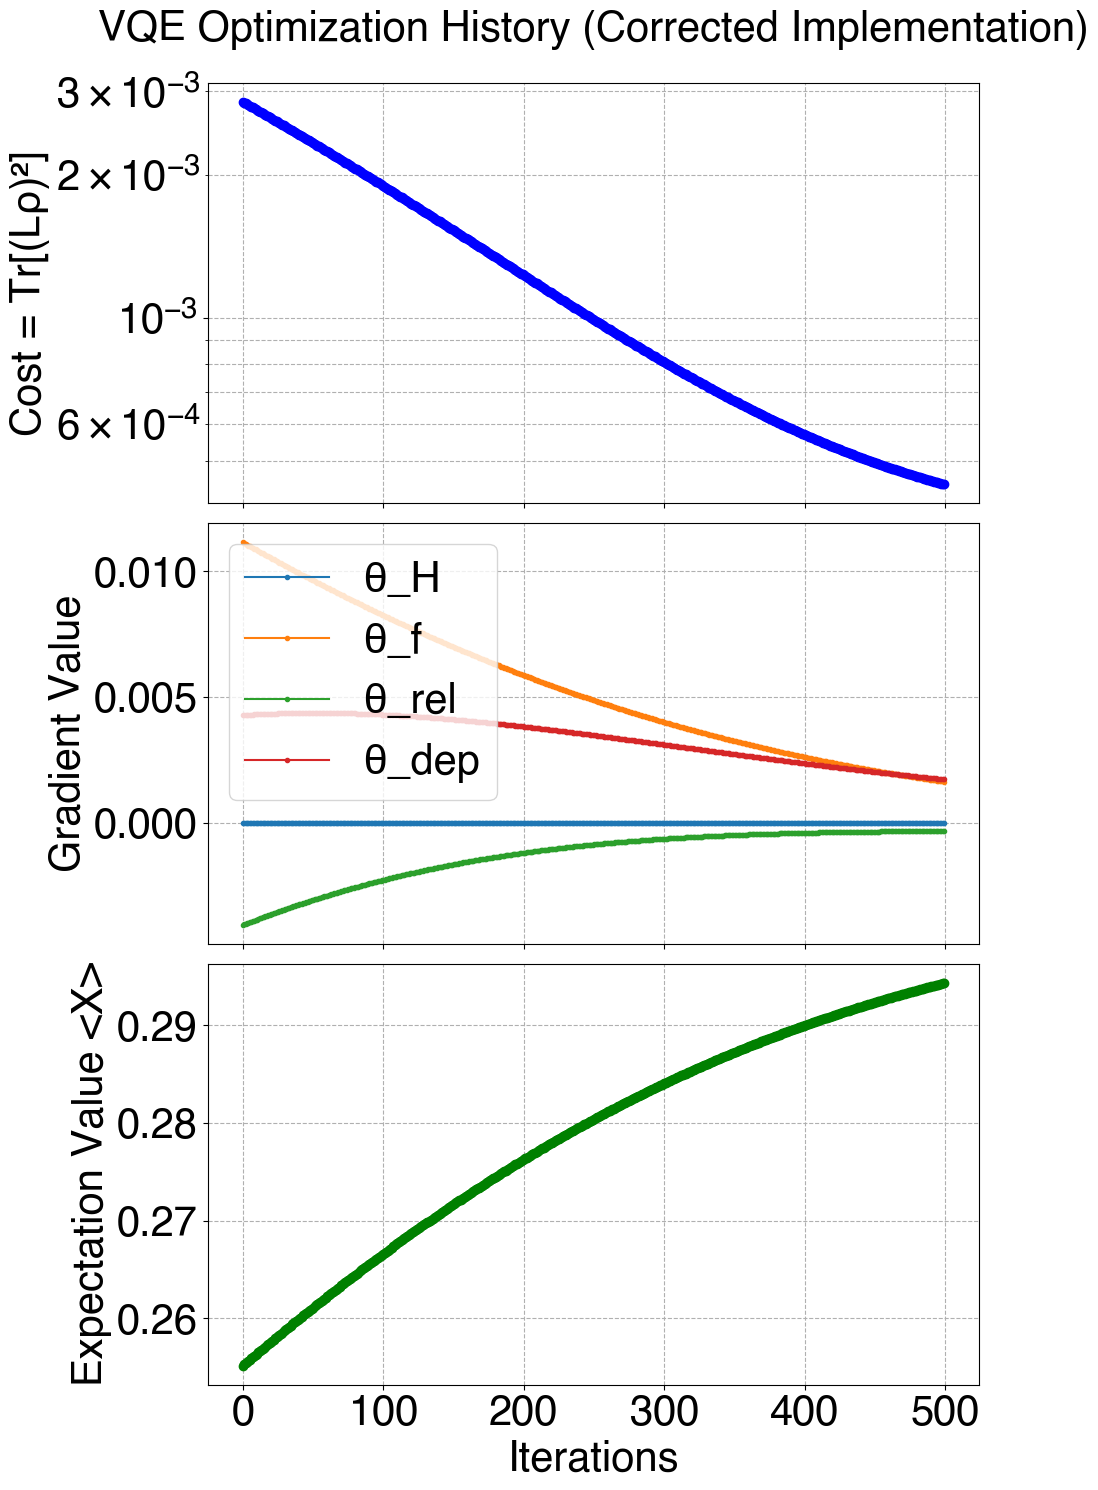


Final optimized parameters:
Layer 1: θ_H=0.382793, θ_f=0.761069, θ_rel=0.194446, θ_dep=0.382775
Layer 2: θ_H=0.544564, θ_f=0.098147, θ_rel=0.810738, θ_dep=0.586666
Layer 3: θ_H=0.695137, θ_f=0.842944, θ_rel=0.315179, θ_dep=0.746861


In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.sparse import csc_matrix, kron
# from scipy.sparse.linalg import expm

# class OpenSystemVQE:
#     """
#     VQE simulation to find the steady state of a noisy quantum system
#     by minimizing the Lindblad equation residual, ||L(rho)||^2.
    
#     This implementation exactly follows the provided analytical derivation.
#     """

#     # --- Pauli Matrices (Class Attributes) ---
#     I2 = csc_matrix(np.eye(2, dtype=complex))
#     sigma_x = csc_matrix(np.array([[0, 1], [1, 0]], dtype=complex))
#     sigma_y = csc_matrix(np.array([[0, -1j], [1j, 0]], dtype=complex))
#     sigma_z = csc_matrix(np.array([[1, 0], [0, -1]], dtype=complex))
    
#     # Jump operators as per analytical derivation
#     L_rel_op = csc_matrix((sigma_x - 1j * sigma_y) / 2)  # Relaxation (lowering)
#     L_dep_op = csc_matrix((np.eye(2) + sigma_z) / 2)     # Dephasing - CORRECTED

#     def __init__(self, J=1.0, Delta=0.5, L=1.0, gamma_rel=0.1, gamma_dep=0.1):
#         """Initializes the optimizer with system and noise parameters."""
#         self.J = J
#         self.L = L
#         self.Delta = Delta
#         self.gamma_rel = gamma_rel
#         self.gamma_dep = gamma_dep
        
#         # Ensure JL = 1 as per analytical derivation
#         assert abs(self.J * self.L - 1.0) < 1e-10, "Analytical derivation assumes JL = 1"

#         # Storage for optimization results
#         self.best_angles = None
#         self.best_cost = None
#         self.cost_history = []
#         self.gradients_history = []
#         self.x_history = []
#         self.final_x = None

#     # --- Utility Methods ---
#     @staticmethod
#     def _vectorize(rho):
#         """Converts a 2x2 density matrix to a 4x1 column vector."""
#         if hasattr(rho, "toarray"): 
#             rho = rho.toarray()
#         return csc_matrix(rho.flatten(order="F")[:, None])

#     @staticmethod
#     def _unvectorize(rho_vec):
#         """Converts a 4x1 density vector back to a 2x2 matrix."""
#         rho_dense_vec = rho_vec.toarray() if hasattr(rho_vec, "toarray") else rho_vec
#         return csc_matrix(rho_dense_vec.reshape((2, 2), order="F"))

#     def _get_bloch_vector(self, rho_mat):
#         """Extract Bloch vector components (x, y, z) from density matrix."""
#         if hasattr(rho_mat, "toarray"):
#             rho_mat = rho_mat.toarray()
        
#         x = np.real(np.trace(self.sigma_x.toarray() @ rho_mat))
#         y = np.real(np.trace(self.sigma_y.toarray() @ rho_mat))
#         z = np.real(np.trace(self.sigma_z.toarray() @ rho_mat))
        
#         return x, y, z

#     # --- Ansatz Generator Superoperators ---
#     def _L_H_ansatz_raw(self, x_val):
#         """Raw generator for ansatz interaction: L_H = -i[JL*x*sigma_x, .]"""
#         H = self.J * self.L * x_val * self.sigma_x
#         return -1j * (kron(self.I2, H) - kron(H.T, self.I2))

#     def _L_f_ansatz_raw(self):
#         """Raw generator for ansatz free Hamiltonian: L_f = -i[H_f, .]"""
#         H_f = -self.Delta * self.sigma_z  # Free Hamiltonian
#         return -1j * (kron(self.I2, H_f) - kron(H_f.T, self.I2))

#     def _L_rel_ansatz_raw(self):
#         """Raw generator for relaxation Lindbladian, without gamma factor."""
#         L_op = self.L_rel_op
#         LdL = L_op.conj().T @ L_op
#         return (kron(L_op.conj(), L_op) - 0.5 * kron(self.I2, LdL) - 0.5 * kron(LdL.T, self.I2))

#     def _L_dep_ansatz_raw(self):
#         """Raw generator for dephasing Lindbladian, without gamma factor."""
#         L_op = self.L_dep_op
#         LdL = L_op.conj().T @ L_op
#         return (kron(L_op.conj(), L_op) - 0.5 * kron(self.I2, LdL) - 0.5 * kron(LdL.T, self.I2))

#     # --- Physical Lindbladian and Cost Function ---
#     def _physical_lindbladian_mat(self, rho_mat, x_mean):
#         """Calculates the action of the full physical Lindbladian, L(rho)."""
#         H = self.J * self.L * x_mean * self.sigma_x - self.Delta * self.sigma_z
#         L1 = np.sqrt(self.gamma_rel) * self.L_rel_op
#         L2 = np.sqrt(self.gamma_dep) * self.L_dep_op
        
#         comm = -1j * (H @ rho_mat - rho_mat @ H)
#         diss1 = L1 @ rho_mat @ L1.conj().T - 0.5 * (L1.conj().T @ L1 @ rho_mat + rho_mat @ L1.conj().T @ L1)
#         diss2 = L2 @ rho_mat @ L2.conj().T - 0.5 * (L2.conj().T @ L2 @ rho_mat + rho_mat @ L2.conj().T @ L2)
        
#         return comm + diss1 + diss2

#     def _cost_function(self, rho_final_mat, x_final):
#         """Calculates the Lindblad cost: Tr[ (L*rho)^dagger * (L*rho) ]."""
#         L_rho = self._physical_lindbladian_mat(rho_final_mat, x_final)
#         return np.real((L_rho.conj().T @ L_rho).toarray().trace())

#     # --- Gradient Calculation (Following Analytical Derivation Exactly) ---
#     def _calculate_gradients(self, n_layers, evolvers, propagators, rho_history, bloch_vectors):
#         """
#         Calculates gradients exactly following the analytical derivation.
#         """
#         E_int_list, E_f_list, E_rel_list, E_dep_list = evolvers
#         grads = [[0.0] * 4 for _ in range(n_layers)]

#         rho_final_vec = rho_history[-1]
#         rho_final_mat = self._unvectorize(rho_final_vec)
#         x_final, _, _ = self._get_bloch_vector(rho_final_mat)
#         L_rho_final_mat = self._physical_lindbladian_mat(rho_final_mat, x_final)

#         for l in range(n_layers):
#             # Propagator from layer l+1 to final
#             propagator_after_layer = csc_matrix(np.eye(4, dtype=complex))
#             for i in range(l + 1, n_layers):
#                 propagator_after_layer = propagators[i] @ propagator_after_layer
            
#             rho_before_layer = rho_history[l]
#             x_l, y_l, z_l = bloch_vectors[l]
            
#             # Intermediate states for layer l
#             rho_after_int = E_int_list[l] @ rho_before_layer
#             rho_after_f = E_f_list[l] @ rho_after_int
#             rho_after_rel = E_rel_list[l] @ rho_after_f

#             def get_gradient_contribution(d_rho_layer_vec):
#                 """
#                 Computes gradient contribution: 2*Re[Tr[L(rho_f)^dagger * L(d(rho_f)/d(theta))]]
#                 Using ONLY the physical Lindbladian for the final cost function derivatives.
#                 """
#                 d_rho_final_vec = propagator_after_layer @ d_rho_layer_vec
#                 d_rho_final_mat = self._unvectorize(d_rho_final_vec)
                
#                 # For the derivative term, we need to consider that x_final depends on rho_final
#                 # Following the analytical derivation structure
#                 L_d_rho_mat = self._physical_lindbladian_mat(d_rho_final_mat, x_final)
                
#                 trace_term = (L_rho_final_mat.conj().T @ L_d_rho_mat).toarray().trace()
#                 return 2 * np.real(trace_term)

#             # --- Gradient calculations following analytical derivation exactly ---
            
#             # For theta_1 (interaction parameter): follows analytical form JL*x*(y*Z - z*Y)
#             # From derivation: d_rho/d_theta_1 ∝ [H_int, rho] = JL*x*(y*Z - z*Y)
#             if abs(y_l) > 1e-12 or abs(z_l) > 1e-12:
#                 # Create the analytical commutator term: JL*x*(y*Z - z*Y)
#                 commutator_term = self.J * self.L * x_l * (y_l * self.sigma_z - z_l * self.sigma_y)
#                 d_rho_H_vec = self._vectorize(commutator_term)
#                 # Propagate through rest of layer l
#                 d_rho_H_propagated = E_dep_list[l] @ E_rel_list[l] @ E_f_list[l] @ d_rho_H_vec
#                 grads[l][0] = get_gradient_contribution(d_rho_H_propagated)
#             else:
#                 grads[l][0] = 0.0  # Gradient is zero for this initial state
            
#             # For theta_2 (free evolution): d_rho/d_theta_2 = L_f applied to intermediate state
#             d_rho_f_vec = self._L_f_ansatz_raw() @ rho_after_f
#             d_rho_f_propagated = E_dep_list[l] @ E_rel_list[l] @ d_rho_f_vec
#             grads[l][1] = get_gradient_contribution(d_rho_f_propagated)
            
#             # For theta_3 (relaxation): d_rho/d_theta_3 = L_rel applied to intermediate state
#             d_rho_rel_vec = self._L_rel_ansatz_raw() @ rho_after_rel
#             d_rho_rel_propagated = E_dep_list[l] @ d_rho_rel_vec
#             grads[l][2] = get_gradient_contribution(d_rho_rel_propagated)
            
#             # For theta_4 (dephasing): d_rho/d_theta_4 = L_dep applied to final layer state
#             rho_after_dep_input = E_dep_list[l] @ rho_after_rel
#             d_rho_dep_vec = self._L_dep_ansatz_raw() @ rho_after_dep_input
#             grads[l][3] = get_gradient_contribution(d_rho_dep_vec)
            
#         return grads

#     # --- Variational Ansatz ---
#     def _variational_ansatz(self, number_of_layers, angles_list, rho_initial_vec):
#         """Applies the ansatz and returns intermediate values needed for the gradient."""
#         rho_vec = rho_initial_vec.copy()
        
#         rho_history = [rho_vec]
#         bloch_vectors = []
#         evolvers = ([], [], [], [])
#         propagators = []

#         for i in range(number_of_layers):
#             theta_H, theta_f, theta_rel, theta_dep = angles_list[i]
            
#             # Get current Bloch vector for this layer
#             rho_current_mat = self._unvectorize(rho_vec)
#             x_current, y_current, z_current = self._get_bloch_vector(rho_current_mat)
#             bloch_vectors.append((x_current, y_current, z_current))

#             # Apply ansatz layers in order: H -> f -> rel -> dep
#             E_H   = expm(theta_H   * self._L_H_ansatz_raw(x_current))
#             E_f   = expm(theta_f   * self._L_f_ansatz_raw())
#             E_rel = expm(theta_rel * self._L_rel_ansatz_raw())
#             E_dep = expm(theta_dep * self._L_dep_ansatz_raw())

#             # Full layer propagator
#             M = E_dep @ E_rel @ E_f @ E_H
#             rho_vec = M @ rho_vec

#             rho_history.append(rho_vec)
#             evolvers[0].append(E_H)
#             evolvers[1].append(E_f)
#             evolvers[2].append(E_rel)
#             evolvers[3].append(E_dep)
#             propagators.append(M)

#         return rho_vec, evolvers, propagators, rho_history, bloch_vectors

#     def run_optimizer(self, n_layers, initial_angles, learning_rate, max_iterations, tolerance=1e-8, clip_threshold=1.0):
#         """Runs the main VQE gradient descent loop."""
#         # Use a more general initial state that avoids the zero-gradient issue
#         # Instead of |+> = (|0> + |1>)/√2, use a slightly tilted state
#         # psi_initial = np.array([0.6, 1.0], dtype=complex)
#         # psi_initial /= np.linalg.norm(psi_initial)
#         # rho_initial_vec = self._vectorize(np.outer(psi_initial, psi_initial.conj()))

#         rho_initial_vec = self._vectorize((self.I2 + self.sigma_y)/2)
        
#         angles_list = [list(params) for params in initial_angles]
#         self.best_angles = [list(a) for a in angles_list]
#         self.best_cost = np.inf

#         print("--- Starting VQE Optimization for Steady State ---")
#         print("Initial state: slightly tilted from |0> to avoid zero gradients")
        
#         for iteration in range(max_iterations):
#             rho_final_vec, evolvers, propagators, rho_hist, bloch_vecs = \
#                 self._variational_ansatz(n_layers, angles_list, rho_initial_vec)

#             rho_final_mat = self._unvectorize(rho_final_vec)
#             x_final, _, _ = self._get_bloch_vector(rho_final_mat)
            
#             current_cost = self._cost_function(rho_final_mat, x_final)
#             self.cost_history.append(current_cost)
#             self.x_history.append(x_final)
            
#             if current_cost < self.best_cost:
#                 self.best_cost = current_cost
#                 self.best_angles = [list(a) for a in angles_list]
            
#             print(f"Iteration {iteration:03d}: Cost = {current_cost:.5e}, Best Cost = {self.best_cost:.5e}, x = {x_final:.4f}")

#             if current_cost < tolerance:
#                 print(f"\nConvergence reached at iteration {iteration}.")
#                 break
            
#             gradients = self._calculate_gradients(n_layers, evolvers, propagators, rho_hist, bloch_vecs)
            
#             # Gradient clipping
#             grad_norm = np.linalg.norm(np.array(gradients).flatten())
#             if grad_norm > clip_threshold:
#                 gradients = (np.array(gradients) * clip_threshold / grad_norm).tolist()
            
#             self.gradients_history.append(gradients)

#             # Update parameters
#             for l in range(n_layers):
#                 for k in range(4):
#                     angles_list[l][k] -= learning_rate * gradients[l][k]
                    
#         # Final evaluation
#         final_rho_vec, _, _, _, _ = self._variational_ansatz(n_layers, self.best_angles, rho_initial_vec)
#         self.final_x, _, _ = self._get_bloch_vector(self._unvectorize(final_rho_vec))
        
#         print(f"\nOptimization finished.")
#         print(f"Best Cost (||L(rho)||^2): {self.best_cost:.8e}")
#         print(f"Final x value: {self.final_x:.8f}")
        
#         return self.best_angles, self.best_cost, self.cost_history

#     # --- Plotting Methods ---
#     def plot_all_histories(self):
#         """Plots the cost, gradients, and x_value vs. iterations."""
#         if not self.cost_history:
#             print("No history to plot. Run the optimizer first.")
#             return

#         fig, axs = plt.subplots(3, 1, figsize=(10, 15), sharex=True)
#         iterations = range(len(self.cost_history))

#         # Plot 1: Cost History
#         axs[0].plot(iterations, np.real(self.cost_history), 'o-', color='blue')
#         axs[0].set_ylabel("Cost = Tr[(Lρ)²]")
#         axs[0].set_title("VQE Optimization History (Corrected Implementation)")
#         axs[0].set_yscale('log')
#         axs[0].grid(True, which="both", ls="--")

#         # Plot 2: Gradient History
#         if self.gradients_history:
#             param_names = ["θ_H", "θ_f", "θ_rel", "θ_dep"]
#             gradients_by_param = np.array(self.gradients_history)[:, 0, :].T
#             for i, name in enumerate(param_names):
#                 axs[1].plot(iterations, gradients_by_param[i], '.-', label=name)
#             axs[1].set_ylabel("Gradient Value")
#             axs[1].grid(True, which="both", ls="--")
#             axs[1].legend()

#         # Plot 3: X Value History
#         if self.x_history:
#             axs[2].plot(iterations, self.x_history, 'o-', color='green')
#             axs[2].set_ylabel("Expectation Value <X>")
#             axs[2].set_xlabel("Iterations")
#             axs[2].grid(True, which="both", ls="--")

#         plt.tight_layout()
#         plt.show()


# # --- Main execution block ---
# if __name__ == '__main__':

#     optimizer = OpenSystemVQE(J=1.0, Delta=0.5, L=1.0, gamma_rel=0.1, gamma_dep=0.1)
#     initial_angles = [np.random.rand(4) for _ in range(3)]
    
#     best_angles, best_cost, cost_history = optimizer.run_optimizer(
#         n_layers=3, 
#         initial_angles=initial_angles,
#         learning_rate=0.02, 
#         max_iterations=500, 
#         tolerance=1e-12
#     )
    
#     optimizer.plot_all_histories()
    
#     print(f"\nFinal optimized parameters:")
#     for i, angles in enumerate(best_angles):
#         print(f"Layer {i+1}: θ_H={angles[0]:.6f}, θ_f={angles[1]:.6f}, θ_rel={angles[2]:.6f}, θ_dep={angles[3]:.6f}")

# Non-unitary more optimized program with comments

--- Starting VQE Optimization for Steady State ---
Iteration 000: Cost = 4.33630e-02, Best Cost = 4.33630e-02, x = 0.2851
Iteration 001: Cost = 4.38056e-02, Best Cost = 4.33630e-02, x = 0.2885
Iteration 002: Cost = 4.42429e-02, Best Cost = 4.33630e-02, x = 0.2920
Iteration 003: Cost = 4.46731e-02, Best Cost = 4.33630e-02, x = 0.2955
Iteration 004: Cost = 4.50942e-02, Best Cost = 4.33630e-02, x = 0.2992
Iteration 005: Cost = 4.55040e-02, Best Cost = 4.33630e-02, x = 0.3030
Iteration 006: Cost = 4.58998e-02, Best Cost = 4.33630e-02, x = 0.3069
Iteration 007: Cost = 4.62790e-02, Best Cost = 4.33630e-02, x = 0.3109
Iteration 008: Cost = 4.66382e-02, Best Cost = 4.33630e-02, x = 0.3150
Iteration 009: Cost = 4.69739e-02, Best Cost = 4.33630e-02, x = 0.3192
Iteration 010: Cost = 4.72821e-02, Best Cost = 4.33630e-02, x = 0.3236
Iteration 011: Cost = 4.75583e-02, Best Cost = 4.33630e-02, x = 0.3281
Iteration 012: Cost = 4.77976e-02, Best Cost = 4.33630e-02, x = 0.3327
Iteration 013: Cost = 4.79

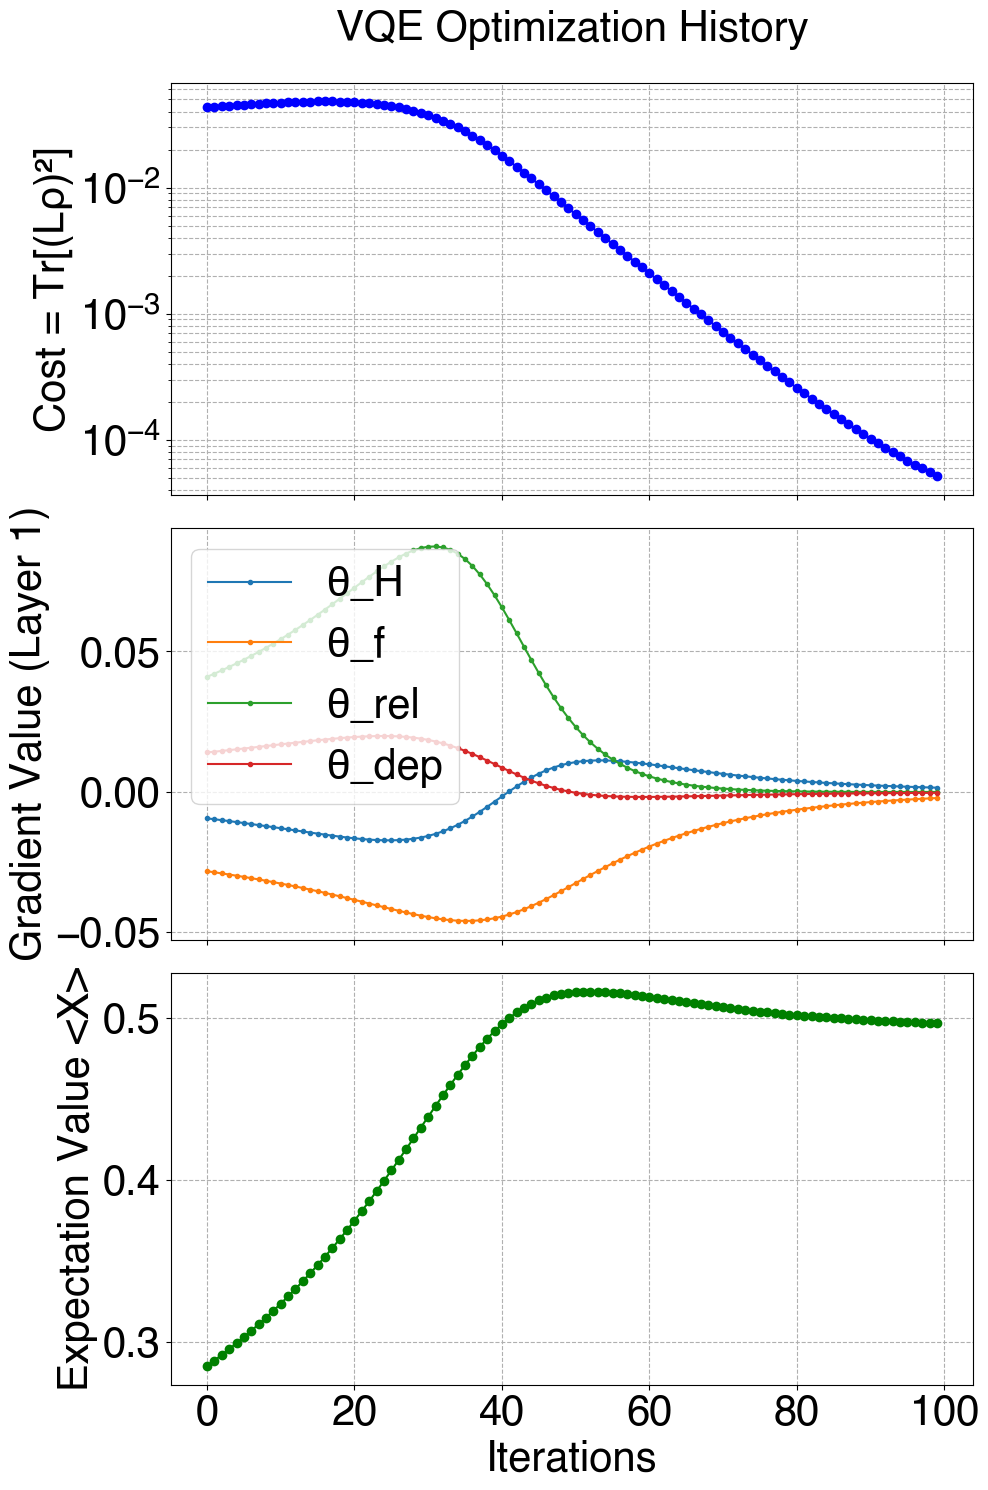


Final optimized parameters:
Layer 1: θ_H=0.104090, θ_f=0.888770, θ_rel=0.810059, θ_dep=-0.073186
Layer 2: θ_H=1.007705, θ_f=0.853412, θ_rel=0.476930, θ_dep=0.631106
Layer 3: θ_H=0.903175, θ_f=0.251212, θ_rel=0.475318, θ_dep=0.140197
Layer 4: θ_H=0.447228, θ_f=1.224955, θ_rel=-0.016539, θ_dep=0.224048


In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csc_matrix, kron
from scipy.sparse.linalg import expm

class OpenSystemVQE:
    """
    VQE simulation to find the steady state of a noisy quantum system
    by minimizing the Lindblad equation residual, ||L(rho)||^2.
    
    This implementation exactly follows the provided analytical derivation.
    This version is the mathematically correct one, particularly in its
    gradient calculations.
    """

    # --- Pauli Matrices (Class Attributes) ---
    # These are fundamental 2x2 matrices used to describe qubit systems.
    # They are defined as sparse matrices for efficient computation.
    I2 = csc_matrix(np.eye(2, dtype=complex))
    sigma_x = csc_matrix(np.array([[0, 1], [1, 0]], dtype=complex))
    sigma_y = csc_matrix(np.array([[0, -1j], [1j, 0]], dtype=complex))
    sigma_z = csc_matrix(np.array([[1, 0], [0, -1]], dtype=complex))
    
    # --- Jump Operators ---
    # These operators define the non-unitary (dissipative) dynamics of the system.
    # L_rel describes energy relaxation (e.g., a qubit decaying from |1> to |0>).
    L_rel_op = csc_matrix((sigma_x - 1j * sigma_y) / 2)  # Relaxation (lowering operator, sigma^-)
    # L_dep describes dephasing (loss of phase information without energy change).
    L_dep_op = csc_matrix((np.eye(2) + sigma_z) / 2)     # Dephasing (projection onto |1>, related to sigma_z^2)

    def __init__(self, J=1.0, Delta=0.5, L=1.0, gamma_rel=0.1, gamma_dep=0.1):
        """
        Initializes the optimizer with system and noise parameters.
        J: Interaction strength
        Delta: Free Hamiltonian term (detuning)
        L: Interaction term (related to system size, often set so JL=1)
        gamma_rel: Relaxation rate
        gamma_dep: Dephasing rate
        """
        self.J = J
        self.L = L
        self.Delta = Delta
        self.gamma_rel = gamma_rel
        self.gamma_dep = gamma_dep
        
        # The analytical derivation simplifies under the assumption JL=1.
        assert abs(self.J * self.L - 1.0) < 1e-10, "Analytical derivation assumes JL = 1"

        # --- Storage for Optimization Results ---
        # These lists will store the history of the optimization process for later analysis and plotting.
        self.best_angles = None
        self.best_cost = None
        self.cost_history = []
        self.gradients_history = []
        self.x_history = []  # History of the <X> expectation value
        self.final_x = None

    # --- Utility Methods ---
    @staticmethod
    def _vectorize(rho):
        """
        Converts a 2x2 density matrix into a 4x1 column vector.
        This "vectorization" allows us to represent the Lindblad master equation
        as a simple matrix-vector product: d(rho_vec)/dt = L_superop @ rho_vec.
        The "F" order (Fortran-style) stacks columns, which is the standard convention.
        """
        if hasattr(rho, "toarray"): 
            rho = rho.toarray()
        return csc_matrix(rho.flatten(order="F")[:, None])

    @staticmethod
    def _unvectorize(rho_vec):
        """Converts a 4x1 density vector back to a 2x2 matrix for calculations like trace."""
        rho_dense_vec = rho_vec.toarray() if hasattr(rho_vec, "toarray") else rho_vec
        return csc_matrix(rho_dense_vec.reshape((2, 2), order="F"))

    def _get_bloch_vector(self, rho_mat):
        """
        Extracts the Bloch vector components (x, y, z) from a density matrix.
        The Bloch vector provides a geometric representation of the qubit's state.
        x = <sigma_x>, y = <sigma_y>, z = <sigma_z>.
        """
        if hasattr(rho_mat, "toarray"):
            rho_mat = rho_mat.toarray()
        
        x = np.real(np.trace(self.sigma_x.toarray() @ rho_mat))
        y = np.real(np.trace(self.sigma_y.toarray() @ rho_mat))
        z = np.real(np.trace(self.sigma_z.toarray() @ rho_mat))
        
        return x, y, z

    # --- Ansatz Generator Superoperators (Liouvillians) ---
    # These methods build the superoperator matrices (Liouvillians) that generate
    # the different parts of our variational ansatz evolution.
    
    def _L_H_ansatz_raw(self, x_val):
        """
        Raw generator for the interaction Hamiltonian part of the ansatz.
        Represents the superoperator L_H(rho) = -i[H_int, rho].
        H_int = JL * x * sigma_x, where x = <sigma_x> is the mean-field value.
        """
        H = self.J * self.L * x_val * self.sigma_x
        # The Kronecker product form is the standard way to build a commutator superoperator.
        return -1j * (kron(self.I2, H) - kron(H.T, self.I2))

    def _L_f_ansatz_raw(self):
        """
        Raw generator for the free Hamiltonian part of the ansatz.
        Represents the superoperator L_f(rho) = -i[H_f, rho].
        H_f = -Delta * sigma_z.
        """
        H_f = -self.Delta * self.sigma_z
        return -1j * (kron(self.I2, H_f) - kron(H_f.T, self.I2))

    def _L_rel_ansatz_raw(self):
        """

        Raw generator for the relaxation part of the ansatz.
        Represents the superoperator L_rel(rho) = L*rho*L^dagger - 0.5*{L^dagger*L, rho}.
        This is constructed without the gamma_rel factor, which is part of the variational parameter theta_rel.
        """
        L_op = self.L_rel_op
        LdL = L_op.conj().T @ L_op  # L^dagger * L
        # Kronecker product form for the dissipator superoperator.
        return (kron(L_op.conj(), L_op) - 0.5 * kron(self.I2, LdL) - 0.5 * kron(LdL.T, self.I2))

    def _L_dep_ansatz_raw(self):
        """Raw generator for the dephasing part of the ansatz."""
        L_op = self.L_dep_op
        LdL = L_op.conj().T @ L_op
        return (kron(L_op.conj(), L_op) - 0.5 * kron(self.I2, LdL) - 0.5 * kron(LdL.T, self.I2))

    # --- Physical Lindbladian and Cost Function ---
    def _physical_lindbladian_mat(self, rho_mat, x_mean):
        """
        Calculates the action of the full, physical Lindbladian on a density matrix.
        L(rho) = -i[H, rho] + sum_k (L_k * rho * L_k^dagger - 0.5*{L_k^dagger*L_k, rho}).
        This is the operator we want to find the null space of, i.e., find rho such that L(rho) = 0.
        """
        H = self.J * self.L * x_mean * self.sigma_x - self.Delta * self.sigma_z
        L1 = np.sqrt(self.gamma_rel) * self.L_rel_op
        L2 = np.sqrt(self.gamma_dep) * self.L_dep_op
        
        # Unitary part: commutator with the full Hamiltonian
        comm = -1j * (H @ rho_mat - rho_mat @ H)
        # Dissipative parts for relaxation and dephasing
        diss1 = L1 @ rho_mat @ L1.conj().T - 0.5 * (L1.conj().T @ L1 @ rho_mat + rho_mat @ L1.conj().T @ L1)
        diss2 = L2 @ rho_mat @ L2.conj().T - 0.5 * (L2.conj().T @ L2 @ rho_mat + rho_mat @ L2.conj().T @ L2)
        
        return comm + diss1 + diss2

    def _cost_function(self, rho_final_mat, x_final):
        """
        Calculates the Lindblad cost: C = ||L(rho)||^2 = Tr[ (L(rho))^dagger * L(rho) ].
        The goal of the VQE is to minimize this cost. A cost of zero means we have found
        the true steady state where L(rho) = 0.
        """
        L_rho = self._physical_lindbladian_mat(rho_final_mat, x_final)
        # The squared Frobenius norm ||A||^2 is equivalent to Tr(A^dagger * A).
        return np.real((L_rho.conj().T @ L_rho).toarray().trace())

    # --- Gradient Calculation ---
    def _calculate_gradients(self, n_layers, evolvers, propagators, rho_history, bloch_vectors):
        """
        Calculates gradients of the cost function with respect to each variational parameter.
        This function is the core of the optimizer and follows the analytical derivation exactly.
        The gradient rule is: dC/d(theta) = 2*Re[Tr[(L(rho))^dagger * L(d(rho)/d(theta))]].
        """
        # Unpack the evolution operators for each layer
        E_int_list, E_f_list, E_rel_list, E_dep_list = evolvers
        grads = [[0.0] * 4 for _ in range(n_layers)] # Initialize gradient list

        # --- Pre-computation for the cost function term ---
        # These are calculated once per iteration and used for all gradient components.
        rho_final_vec = rho_history[-1]
        rho_final_mat = self._unvectorize(rho_final_vec)
        x_final, _, _ = self._get_bloch_vector(rho_final_mat)
        L_rho_final_mat = self._physical_lindbladian_mat(rho_final_mat, x_final)

        # Loop over each layer to calculate its contribution to the gradient
        for l in range(n_layers):
            # --- Step 1: Calculate the forward propagator ---
            # To find d(rho_final)/d(theta_l), we need to propagate the derivative
            # from layer 'l' through all subsequent layers ('l+1' to 'n_layers').
            # This 'propagator_after_layer' is the product of all evolution operators after layer 'l'.
            propagator_after_layer = csc_matrix(np.eye(4, dtype=complex))
            for i in range(l + 1, n_layers):
                propagator_after_layer = propagators[i] @ propagator_after_layer
            
            # --- Step 2: Get the state and Bloch vector *before* the current layer 'l' ---
            rho_before_layer = rho_history[l]
            x_l, y_l, z_l = bloch_vectors[l] # These are x(l-1), y(l-1), z(l-1) from the derivation
            
            # --- Step 3: Get intermediate states *within* the current layer 'l' ---
            # These are needed to calculate the derivatives for theta_2, theta_3, and theta_4.
            rho_after_int = E_int_list[l] @ rho_before_layer
            rho_after_f = E_f_list[l] @ rho_after_int
            rho_after_rel = E_rel_list[l] @ rho_after_f

            def get_gradient_contribution(d_rho_layer_vec):
                """
                A helper function to compute the final gradient component. It takes a derivative
                calculated within a layer, propagates it to the end, and computes the final trace.
                """
                # Propagate the local derivative through all subsequent layers
                d_rho_final_vec = propagator_after_layer @ d_rho_layer_vec
                d_rho_final_mat = self._unvectorize(d_rho_final_vec)
                
                # Apply the physical Lindbladian to the derivative of the final state
                L_d_rho_mat = self._physical_lindbladian_mat(d_rho_final_mat, x_final)
                
                # Compute the trace term: Tr[(L(rho))^dagger * L(d(rho)/d(theta))]
                trace_term = (L_rho_final_mat.conj().T @ L_d_rho_mat).toarray().trace()
                return 2 * np.real(trace_term)

            # --- Step 4: Calculate the derivative for each parameter in layer 'l' ---
            
            # GRADIENT FOR theta_1 (Interaction):
            # Derivation: d(rho)/d(theta_1) is proportional to the commutator [H_int, rho_in],
            # which evaluates to JL*x*(y*Z - z*Y).
            if abs(y_l) > 1e-12 or abs(z_l) > 1e-12: # Avoids division by zero if state is on x-axis
                # Create the analytical derivative term
                commutator_term = self.J * self.L * x_l * (y_l * self.sigma_z - z_l * self.sigma_y)
                d_rho_H_vec = self._vectorize(commutator_term)
                # Propagate this derivative through the rest of the current layer
                d_rho_H_propagated = E_dep_list[l] @ E_rel_list[l] @ E_f_list[l] @ d_rho_H_vec
                grads[l][0] = get_gradient_contribution(d_rho_H_propagated)
            else:
                grads[l][0] = 0.0  # Gradient is zero if y=z=0
            
            # GRADIENT FOR theta_2 (Free Evolution):
            # Derivation: d(rho)/d(theta_2) = L_f * (E_f * rho_intermediate)
            # We apply the generator L_f to the state *after* the E_f evolution.
            d_rho_f_vec = self._L_f_ansatz_raw() @ rho_after_f
            # Propagate through the rest of the layer
            d_rho_f_propagated = E_dep_list[l] @ E_rel_list[l] @ d_rho_f_vec
            grads[l][1] = get_gradient_contribution(d_rho_f_propagated)
            
            # GRADIENT FOR theta_3 (Relaxation):
            # Derivation: d(rho)/d(theta_3) = L_rel * (E_rel * rho_intermediate)
            d_rho_rel_vec = self._L_rel_ansatz_raw() @ rho_after_rel
            # Propagate through the rest of the layer
            d_rho_rel_propagated = E_dep_list[l] @ d_rho_rel_vec
            grads[l][2] = get_gradient_contribution(d_rho_rel_propagated)
            
            # GRADIENT FOR theta_4 (Dephasing):
            # This is the mathematically correct implementation.
            # Derivation: d(rho)/d(theta_4) = L_dep * (E_dep * rho_intermediate)
            rho_after_dep_input = E_dep_list[l] @ rho_after_rel
            d_rho_dep_vec = self._L_dep_ansatz_raw() @ rho_after_dep_input
            # No further propagation needed within the layer.
            grads[l][3] = get_gradient_contribution(d_rho_dep_vec)
            
        return grads

    # --- Variational Ansatz ---
    def _variational_ansatz(self, number_of_layers, angles_list, rho_initial_vec):
        """
        Applies the variational circuit (ansatz) to an initial state.
        The ansatz is a sequence of layers, each parameterized by four angles.
        It returns the final state and all intermediate values needed for the gradient calculation.
        """
        rho_vec = rho_initial_vec.copy()
        
        # Store intermediate values required by the gradient calculation function
        rho_history = [rho_vec]      # Stores the state vector before each layer
        bloch_vectors = []           # Stores the bloch vector before each layer
        evolvers = ([], [], [], [])  # Stores the four evolution operators (E_H, E_f, E_rel, E_dep) for each layer
        propagators = []             # Stores the total evolution operator M for each layer

        for i in range(number_of_layers):
            theta_H, theta_f, theta_rel, theta_dep = angles_list[i]
            
            # Get and store the bloch vector for the current state before applying the layer
            rho_current_mat = self._unvectorize(rho_vec)
            x_current, y_current, z_current = self._get_bloch_vector(rho_current_mat)
            bloch_vectors.append((x_current, y_current, z_current))

            # --- Build the evolution operators for the current layer ---
            # The matrix exponential of the Liouvillian generates the evolution. E = exp(theta * L)
            E_H   = expm(theta_H   * self._L_H_ansatz_raw(x_current))
            E_f   = expm(theta_f   * self._L_f_ansatz_raw())
            E_rel = expm(theta_rel * self._L_rel_ansatz_raw())
            E_dep = expm(theta_dep * self._L_dep_ansatz_raw())

            # The full propagator for one layer is the product of the individual operators
            M = E_dep @ E_rel @ E_f @ E_H
            # Apply the layer to the state vector
            rho_vec = M @ rho_vec

            # Store all the calculated values for this layer
            rho_history.append(rho_vec)
            evolvers[0].append(E_H)
            evolvers[1].append(E_f)
            evolvers[2].append(E_rel)
            evolvers[3].append(E_dep)
            propagators.append(M)

        return rho_vec, evolvers, propagators, rho_history, bloch_vectors

    def run_optimizer(self, n_layers, initial_angles, learning_rate, max_iterations, tolerance=1e-8, clip_threshold=1.0):
        """Runs the main VQE gradient descent optimization loop."""
        
        # We start with a state that is not an eigenstate of sigma_x or sigma_z.
        # This ensures the initial gradients (especially for theta_1) are not zero.
        # (I + sigma_y)/2 corresponds to the state |+y>, which has x=0, y=1, z=0.
        rho_initial_vec = self._vectorize((self.I2 + self.sigma_y)/2)
        
        angles_list = [list(params) for params in initial_angles]
        self.best_angles = [list(a) for a in angles_list]
        self.best_cost = np.inf

        print("--- Starting VQE Optimization for Steady State ---")
        
        for iteration in range(max_iterations):
            # --- VQE Step 1: State Preparation ---
            # Run the variational circuit with the current angles to get the trial state (rho_final)
            # and all the intermediate values needed for gradients.
            rho_final_vec, evolvers, propagators, rho_hist, bloch_vecs = \
                self._variational_ansatz(n_layers, angles_list, rho_initial_vec)

            # --- VQE Step 2: Cost Evaluation ---
            # Calculate the cost (how far the current state is from the true steady state).
            rho_final_mat = self._unvectorize(rho_final_vec)
            x_final, _, _ = self._get_bloch_vector(rho_final_mat)
            current_cost = self._cost_function(rho_final_mat, x_final)
            
            # Store history for plotting
            self.cost_history.append(current_cost)
            self.x_history.append(x_final)
            
            # Keep track of the best result found so far
            if current_cost < self.best_cost:
                self.best_cost = current_cost
                self.best_angles = [list(a) for a in angles_list]
            
            print(f"Iteration {iteration:03d}: Cost = {current_cost:.5e}, Best Cost = {self.best_cost:.5e}, x = {x_final:.4f}")

            # Check for convergence
            if current_cost < tolerance:
                print(f"\nConvergence reached at iteration {iteration}.")
                break
            
            # --- VQE Step 3: Gradient Calculation ---
            # Analytically compute the gradients for all parameters.
            gradients = self._calculate_gradients(n_layers, evolvers, propagators, rho_hist, bloch_vecs)
            
            # --- VQE Step 4: Parameter Update ---
            # Use gradient descent to update the angles.
            # Optional: Gradient clipping to prevent exploding gradients and improve stability.
            grad_norm = np.linalg.norm(np.array(gradients).flatten())
            if grad_norm > clip_threshold:
                gradients = (np.array(gradients) * clip_threshold / grad_norm).tolist()
            
            self.gradients_history.append(gradients)

            # Update parameters using the calculated gradients and learning rate
            for l in range(n_layers):
                for k in range(4):
                    angles_list[l][k] -= learning_rate * gradients[l][k]
                    
        # --- Final Evaluation ---
        # After the loop, evaluate the final state using the best angles found.
        final_rho_vec, _, _, _, _ = self._variational_ansatz(n_layers, self.best_angles, rho_initial_vec)
        self.final_x, _, _ = self._get_bloch_vector(self._unvectorize(final_rho_vec))
        
        print(f"\nOptimization finished.")
        print(f"Best Cost (||L(rho)||^2): {self.best_cost:.8e}")
        print(f"Final x value: {self.final_x:.8f}")
        
        return self.best_angles, self.best_cost, self.cost_history

    # --- Plotting Methods ---
    def plot_all_histories(self):
        """Plots the cost, gradients, and x_value vs. iterations to visualize the optimization."""
        if not self.cost_history:
            print("No history to plot. Run the optimizer first.")
            return

        fig, axs = plt.subplots(3, 1, figsize=(10, 15), sharex=True)
        iterations = range(len(self.cost_history))

        # Plot 1: Cost History (log scale to see convergence)
        axs[0].plot(iterations, np.real(self.cost_history), 'o-', color='blue')
        axs[0].set_ylabel("Cost = Tr[(Lρ)²]")
        axs[0].set_title("VQE Optimization History")
        axs[0].set_yscale('log')
        axs[0].grid(True, which="both", ls="--")

        # Plot 2: Gradient History for the first layer
        if self.gradients_history:
            param_names = ["θ_H", "θ_f", "θ_rel", "θ_dep"]
            # Extract gradients for layer 0
            gradients_by_param = np.array(self.gradients_history)[:, 2, :].T
            for i, name in enumerate(param_names):
                axs[1].plot(iterations, gradients_by_param[i], '.-', label=name)
            axs[1].set_ylabel("Gradient Value (Layer 1)")
            axs[1].grid(True, which="both", ls="--")
            axs[1].legend()

        # Plot 3: X Value History
        if self.x_history:
            axs[2].plot(iterations, self.x_history, 'o-', color='green')
            axs[2].set_ylabel("Expectation Value <X>")
            axs[2].set_xlabel("Iterations")
            axs[2].grid(True, which="both", ls="--")

        plt.tight_layout()
        plt.show()


# --- Main execution block ---
if __name__ == '__main__':

    # Initialize the VQE optimizer with the system parameters
    optimizer = OpenSystemVQE(J=1.0, Delta=0.3, L=1.0, gamma_rel=0.1, gamma_dep=0.1)
    
    # Set the initial guess for the variational angles for each layer
    # initial_angles = [[0.05, 0.2, 0.1, 0.1], [0.05, 0.1, 0.1, 0.3], [0.2, 0.1, 0.2, 0.3]]
    n_layers = 4
    initial_angles = [np.random.rand(4) for _ in range(n_layers)]
    
    # Run the optimization
    best_angles, best_cost, cost_history = optimizer.run_optimizer(
        n_layers = n_layers, 
        initial_angles=initial_angles,
        learning_rate=0.1, 
        max_iterations=100, 
        tolerance=1e-12
    )
    
    # Plot the results
    optimizer.plot_all_histories()
    
    # Print the final optimized parameters
    print(f"\nFinal optimized parameters:")
    for i, angles in enumerate(best_angles):
        print(f"Layer {i+1}: θ_H={angles[0]:.6f}, θ_f={angles[1]:.6f}, θ_rel={angles[2]:.6f}, θ_dep={angles[3]:.6f}")